## TCRE Analysis

Here is some code that uses xarray to open ESM4 data, calculate global averages for surface warming, and plot the relationship between surface warming and emissions

Exercise in looking at internal ESM4 output/naming conventions/jupyter notebook creation


Written by Katherine Turner, 05 Jan 2023

In [1]:
import matplotlib.pyplot as plt
import momlevel as ml
import mplsettings
import nc_time_axis
import numpy as np
import xarray as xr

In [2]:
fpath = "/Users/keturner/TCRE/ESM4_1pctCO2_D1/gfdl.ncrc4-intel16-prod-openmp/pp/"
vpath = "ts/monthly/5yr/"

In [3]:
# atmos.static.nc contains constant fields for atmospheric variables - area, orography, etc.

adata = xr.open_dataset(f"{fpath}atmos/atmos.static.nc")
adata

<xarray.Dataset>
Dimensions:      (scalar_axis: 1, lev: 49, nv: 2, phalf: 50, lat: 180,
                  lon: 288, bnds: 2)
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * lev          (lev) float64 0.998 0.9928 0.9854 ... 3.934e-05 1.849e-05
  * nv           (nv) float64 1.0 2.0
  * phalf        (phalf) float64 0.01 0.02697 0.05171 ... 989.7 995.9 1e+03
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * bnds         (bnds) float64 1.0 2.0
Data variables: (12/18)
    p500         (scalar_axis) float64 ...
    p850         (scalar_axis) float64 ...
    height10m    (scalar_axis) float64 ...
    height2m     (scalar_axis) float64 ...
    ap           (lev) float64 ...
    ap_bnds      (lev, nv) float64 ...
    ...           ...
    lat_bnds     (lat, bnds) float64 ...
    lon_bnds     (lon, bnds) float64 ...
    orog         (lat, lon) float32 ...
    sftlf        (lat, lon) float32 ...
    land_mask    (lat, lon) float32 ...
    zsurf        (lat, lon) float32 ...
Attributes:
    external_variables:  ps ps

In [4]:
# open files for global temperatures
# for now, I don't have preindustrial averages so I won't take any difference
# I'm just focusing on calculating annual averages and global averages at this point

ds1 = xr.open_mfdataset(
    f"{fpath}atmos/{vpath}/atmos.*", use_cftime=True
)  # use_cftime=True prevents errors from reading time axis
ds1.t_ref

<xarray.DataArray 't_ref' (time: 1800, lat: 180, lon: 288)>
dask.array<concatenate, shape=(1800, 180, 288), dtype=float32, chunksize=(60, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
Attributes:
    long_name:      temperature at 2 m
    units:          deg_k
    valid_range:    [100. 400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [5]:
t_ref_ann = ml.util.annual_average(
    ds1.t_ref
)  # ml includes algorithm for taking weighted annual averages
t_ref_ann

<xarray.DataArray 't_ref' (time: 150, lat: 180, lon: 288)>
dask.array<concatenate, shape=(150, 180, 288), dtype=float64, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-07-02 12:00:00 ... 0150-07-02 12:00:00
Attributes:
    long_name:      temperature at 2 m
    units:          deg_k
    valid_range:    [100. 400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [6]:
mplsettings.setup_plots(dpi=200, font="Verdana")  # sets viewing resolution for figures

Text(0.5, 1.0, '2-temperature')

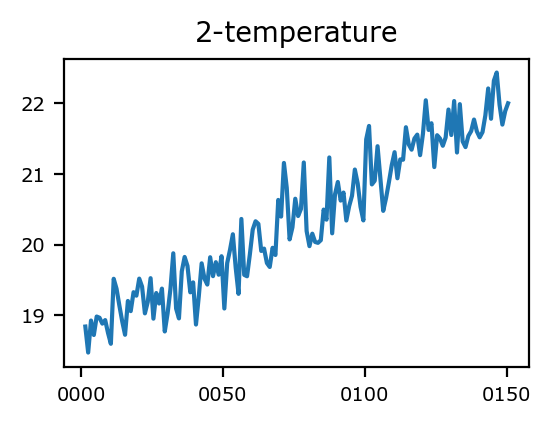

In [7]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)

tax = t_ref_ann.time.values
ax.plot(tax, t_ref_ann[:, 121, 270].data - 273.15)
plt.title("2-temperature", fontsize=10)
# plt.savefig("tempplt.pdf", bbox_inches="tight") # bbox_inches helps to make sure things do not get cut off of figures

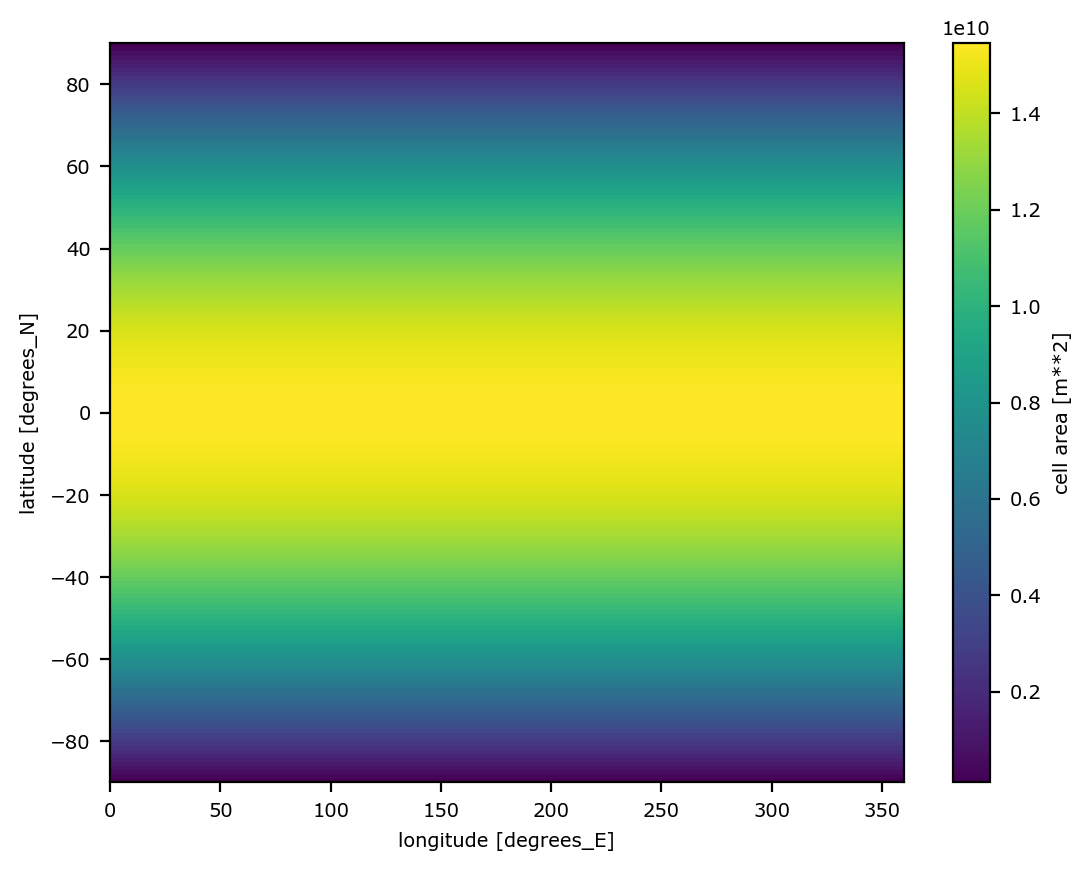

In [8]:
# moving on to global averages. We have the area of each grid cell in that atmos file we first opened
adata.area.plot()

In [9]:
temp_weighted = t_ref_ann.weighted(adata.area)
temp_weighted

DataArrayWeighted with weights along dimensions: lat, lon

Text(0.5, 1.0, 'Global 2m-temperature, $^{\\circ}$C')

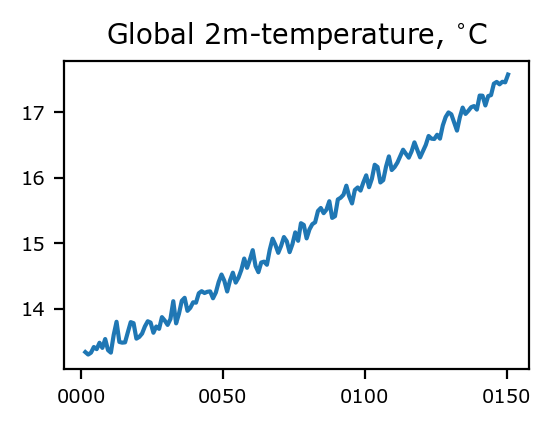

In [10]:
temp_glob = temp_weighted.mean(("lat", "lon"))

fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)

ax.plot(tax, temp_glob.data - 273.15)
plt.title("Global 2m-temperature, $^{\circ}$C", fontsize=10)
# plt.savefig("temp_glob.png", bbox_inches="tight")

In [11]:
# open files for carbon fluxes

ds2 = xr.open_mfdataset(
    f"{fpath}atmos_co2_level/{vpath}/atmos*co2_mol_flux.nc", use_cftime=True
)
ds2.co2_mol_flux

<xarray.DataArray 'co2_mol_flux' (time: 1800, lat: 180, lon: 288)>
dask.array<concatenate, shape=(1800, 180, 288), dtype=float32, chunksize=(60, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
Attributes:
    long_name:      flux of carbon dioxide
    units:          mol CO2/(m2 s)
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [12]:
# now we have to sum up cumulatively to find total changes in combined land and ocean inventories
# caveats -- I'm assuming we don't need to re-sample fluxes at 1st or end of the month (not sure about this)
# and we are straight ignoring sediment carbon release

flux_glob = (ds2.co2_mol_flux * adata.area).sum(("lat", "lon"))
# plt.plot(flux_glob.data)

In [ ]:
# output is in m-2 s-1 - for our global integral we now have s-1
flux_glob_ann = ml.util.annual_average(flux_glob)
yr2sec = 365 * 24 * 60**2
mol2PgC = 12.011 * 1e-15

sink_LO = (flux_glob_ann * yr2sec).cumsum(dim="time")
sink_LO

In [ ]:
fig = plt.figure(figsize=(3, 2))
ax = plt.subplot(111)

ax.plot(tax, sink_LO.data * mol2PgC * -1)
plt.title("Cumulative land + ocean carbon uptake, PgC", fontsize=10)
# plt.savefig("cuptake_lo.png", bbox_inches="tight")

In [ ]:
sink_LO[80].compute() * mol2PgC

In [ ]:
# final pieces of the puzzle - atmospheric CO2 concentrations and atmospheric restoring term
# for atmospheric CO2 concentrations, 1 ppm CO2 = 2.13 PgC
# for restoring term, output is in mol CO2 (m2 s)-1

ds3 = xr.open_mfdataset(
    f"{fpath}atmos_co2_level/{vpath}/atmos*XCO2.nc", use_cftime=True
)

XCO2_weighted = ds3.XCO2.weighted(adata.area)
XCO2_glob = XCO2_weighted.mean(("lat", "lon"))
XCO2_glob_ann = ml.util.annual_average(XCO2_glob)

In [ ]:
ds4 = xr.open_mfdataset(
    f"{fpath}atmos_co2_level/{vpath}/atmos*co2_restore.nc", use_cftime=True
)
rs_column = ds4.co2_restore.sum(axis=1)

In [ ]:
# convert restoring term into global restoring term by:
# 1. integrating over time and space
# 2. converting into PgC

rs_glob = (rs_column * adata.area).sum(("lat", "lon"))
rs_glob_ann = ml.util.annual_average(rs_glob)

In [ ]:
sink_resid = (rs_glob_ann * yr2sec).cumsum(dim="time")

In [ ]:
DIa = (XCO2_glob_ann - XCO2_glob_ann[0]) * 1e6 * 2.13
DIlo = sink_LO * mol2PgC * -1
DIres = sink_resid * mol2PgC  # times ±1??

In [ ]:
plt.figure(figsize=(3.5, 3))
DIa.plot()
DIlo.plot()
DIres.plot()